In [1]:
from setup_extended_corpus import build_corpora
corpora = build_corpora()
#print(corpora)

[nltk_data] Downloading package treebank to
[nltk_data]     /Users/sharadsharma/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


Selected Category: extended_description
extended_description has 414 samples;
extended_installation has 103 samples;
extended_invocation has 103 samples;
extended_citation has 103 samples;
Selected Category: extended_installation
extended_description has 274 samples;
extended_installation has 1096 samples;
extended_invocation has 274 samples;
extended_citation has 274 samples;
Selected Category: extended_invocation
extended_description has 380 samples;
extended_installation has 380 samples;
extended_invocation has 1523 samples;
extended_citation has 380 samples;
Selected Category: extended_citation
extended_description has 102 samples;
extended_installation has 102 samples;
extended_invocation has 102 samples;
extended_citation has 409 samples;


## We try out the top 4 models for description on our extended corpus

In [168]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate,StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pandas as pd
from sklearn.metrics import precision_score,recall_score,roc_curve, auc, precision_recall_curve, average_precision_score
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import re
from sklearn.model_selection import GridSearchCV
import nltk
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

ext_desc=corpora['extended_description']
#del ext_desc['Unnamed: 0']

X_desc, Y_desc = ext_desc.excerpt, ext_desc.extended_description


## 1) CountVectorizer + LogisticRegression

              precision    recall  f1-score   support

       False       0.85      0.80      0.82        79
        True       0.85      0.89      0.87       102

    accuracy                           0.85       181
   macro avg       0.85      0.84      0.85       181
weighted avg       0.85      0.85      0.85       181

null accuracy: 56.35%
accuracy score: 85.08%
model is 28.73% more accurate than null accuracy


accuracy score: 85.08%
Precision score : 0.8504672897196262
Recall score  : 0.8921568627450981


[0.77241379 0.72413793 0.83448276 0.75694444 0.8125    ]
Mean accuracy of CV: 0.780095785440613
Description ROC


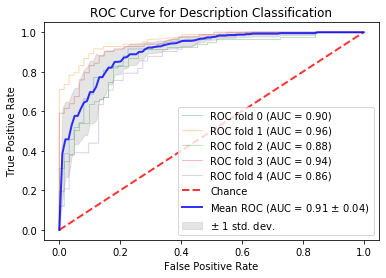

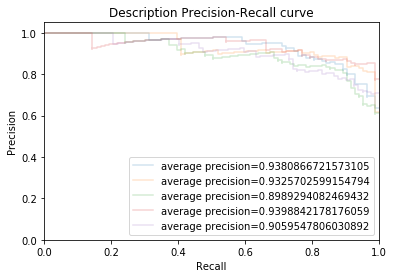

In [75]:
pipeline = make_pipeline(CountVectorizer(), LogisticRegression(solver='liblinear'))
X_train, X_test, Y_train, Y_test = train_test_split(X_desc, Y_desc)


def display_accuracy_score(y_test, y_pred_class):
    score = accuracy_score(y_test, y_pred_class)
    print('accuracy score: %s' % '{:.2%}'.format(score))
    return score

def display_null_accuracy(y_test):
    value_counts = pd.value_counts(y_test)
    null_accuracy = max(value_counts) / float(len(y_test))
    print('null accuracy: %s' % '{:.2%}'.format(null_accuracy))
    return null_accuracy

def display_accuracy_difference(y_test, y_pred_class):
    null_accuracy = display_null_accuracy(y_test)
    accuracy_score = display_accuracy_score(y_test, y_pred_class)
    difference = accuracy_score - null_accuracy
    if difference > 0:
        print('model is %s more accurate than null accuracy' % '{:.2%}'.format(difference))
    elif difference < 0:
        print('model is %s less accurate than null accuracy' % '{:.2%}'.format(abs(difference)))
    elif difference == 0:
        print('model is exactly as accurate as null accuracy')
    return null_accuracy, accuracy_score


pipeline.fit(X_train, Y_train)

y_pred_class = pipeline.predict(X_test)
y_pred_vals = pipeline.predict_proba(X_test)
results_df = pd.DataFrame({"x_test": X_test,  "y_TF_pred": y_pred_class, "y_actual": Y_test})
#print(results_df)
#print(confusion_matrix(y_test, y_pred_class))
#print('-' * 75 + '\nClassification Report\n')
print(classification_report(Y_test, y_pred_class))

display_accuracy_difference(Y_test, y_pred_class)
print('\n')
display_accuracy_score(Y_test, y_pred_class)
print('Precision score :',precision_score(Y_test, y_pred_class))
print('Recall score  :',recall_score(Y_test, y_pred_class))

print('\n')

cv = StratifiedKFold(n_splits = 5, shuffle=True)

cv_results = cross_validate(pipeline, X_desc, Y_desc, cv=5,scoring='accuracy')
print(cv_results['test_score'])
print('Mean accuracy of CV:',cv_results['test_score'].mean())

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
    
i = 0
print('Description ROC')
for train, test in cv.split(X_desc, Y_desc):
    probas_ = pipeline.fit(X_desc[train], Y_desc[train]).predict_proba(X_desc[test])
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(Y_desc[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i+=1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Description Classification')
plt.legend(loc="lower right")
plt.show()


for train, test in cv.split(X_desc, Y_desc):
    probas_ = pipeline.fit(X_desc[train], Y_desc[train]).predict_proba(X_desc[test])
    precision, recall, _ = precision_recall_curve(Y_desc[test], probas_[:,1])

    plt.step(recall, precision, alpha=0.2,
             where='post', label=f'average precision={average_precision_score(Y_desc[test], probas_[:,1])}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
plt.title('Description Precision-Recall curve'.format(
          average_precision_score(Y_desc[test], probas_[:,1])))
plt.legend(loc="lower right")
plt.show()




## 2) TfidfVectorizer + LogisticRegression

              precision    recall  f1-score   support

       False       0.88      0.73      0.79        77
        True       0.82      0.92      0.87       104

    accuracy                           0.84       181
   macro avg       0.85      0.83      0.83       181
weighted avg       0.84      0.84      0.84       181

null accuracy: 57.46%
accuracy score: 83.98%
model is 26.52% more accurate than null accuracy


accuracy score: 83.98%
Precision score : 0.8205128205128205
Recall score  : 0.9230769230769231


[0.82758621 0.70344828 0.8137931  0.77083333 0.84027778]
Mean accuracy of CV: 0.7911877394636015
Description ROC


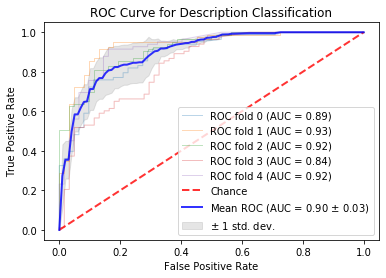

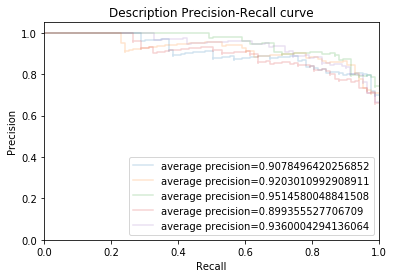

In [76]:
pipeline = make_pipeline(TfidfVectorizer(), LogisticRegression(solver='liblinear'))
X_train, X_test, Y_train, Y_test = train_test_split(X_desc, Y_desc)


def display_accuracy_score(y_test, y_pred_class):
    score = accuracy_score(y_test, y_pred_class)
    print('accuracy score: %s' % '{:.2%}'.format(score))
    return score

def display_null_accuracy(y_test):
    value_counts = pd.value_counts(y_test)
    null_accuracy = max(value_counts) / float(len(y_test))
    print('null accuracy: %s' % '{:.2%}'.format(null_accuracy))
    return null_accuracy

def display_accuracy_difference(y_test, y_pred_class):
    null_accuracy = display_null_accuracy(y_test)
    accuracy_score = display_accuracy_score(y_test, y_pred_class)
    difference = accuracy_score - null_accuracy
    if difference > 0:
        print('model is %s more accurate than null accuracy' % '{:.2%}'.format(difference))
    elif difference < 0:
        print('model is %s less accurate than null accuracy' % '{:.2%}'.format(abs(difference)))
    elif difference == 0:
        print('model is exactly as accurate as null accuracy')
    return null_accuracy, accuracy_score


pipeline.fit(X_train, Y_train)

y_pred_class = pipeline.predict(X_test)
y_pred_vals = pipeline.predict_proba(X_test)
results_df = pd.DataFrame({"x_test": X_test,  "y_TF_pred": y_pred_class, "y_actual": Y_test})
#print(results_df)
#print(confusion_matrix(y_test, y_pred_class))
#print('-' * 75 + '\nClassification Report\n')
print(classification_report(Y_test, y_pred_class))

display_accuracy_difference(Y_test, y_pred_class)
print('\n')
display_accuracy_score(Y_test, y_pred_class)
print('Precision score :',precision_score(Y_test, y_pred_class))
print('Recall score  :',recall_score(Y_test, y_pred_class))

print('\n')

cv = StratifiedKFold(n_splits = 5, shuffle=True)

cv_results = cross_validate(pipeline, X_desc, Y_desc, cv=5,scoring='accuracy')
print(cv_results['test_score'])
print('Mean accuracy of CV:',cv_results['test_score'].mean())

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
    
i = 0
print('Description ROC')
for train, test in cv.split(X_desc, Y_desc):
    probas_ = pipeline.fit(X_desc[train], Y_desc[train]).predict_proba(X_desc[test])
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(Y_desc[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i+=1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Description Classification')
plt.legend(loc="lower right")
plt.show()


for train, test in cv.split(X_desc, Y_desc):
    probas_ = pipeline.fit(X_desc[train], Y_desc[train]).predict_proba(X_desc[test])
    precision, recall, _ = precision_recall_curve(Y_desc[test], probas_[:,1])

    plt.step(recall, precision, alpha=0.2,
             where='post', label=f'average precision={average_precision_score(Y_desc[test], probas_[:,1])}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
plt.title('Description Precision-Recall curve'.format(
          average_precision_score(Y_desc[test], probas_[:,1])))
plt.legend(loc="lower right")
plt.show()



## 3) TfidfVectorizer + NaiveBayes

              precision    recall  f1-score   support

       False       0.97      0.55      0.70        71
        True       0.77      0.99      0.87       110

    accuracy                           0.82       181
   macro avg       0.87      0.77      0.79       181
weighted avg       0.85      0.82      0.80       181

null accuracy: 60.77%
accuracy score: 81.77%
model is 20.99% more accurate than null accuracy


accuracy score: 81.77%
Precision score : 0.7730496453900709
Recall score  : 0.990909090909091


[0.7862069  0.73793103 0.71724138 0.72916667 0.75694444]
Mean accuracy of CV: 0.7454980842911878
Description ROC


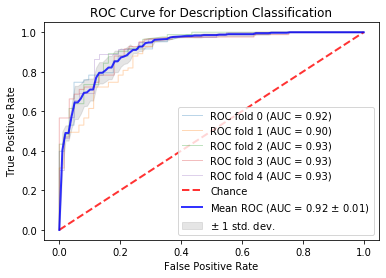

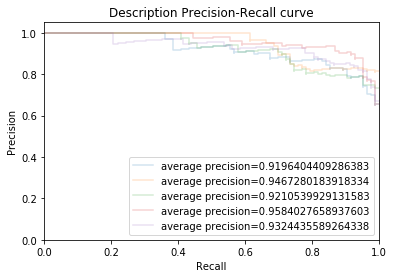

In [78]:
pipeline = make_pipeline(TfidfVectorizer(), MultinomialNB())
X_train, X_test, Y_train, Y_test = train_test_split(X_desc, Y_desc)


def display_accuracy_score(y_test, y_pred_class):
    score = accuracy_score(y_test, y_pred_class)
    print('accuracy score: %s' % '{:.2%}'.format(score))
    return score

def display_null_accuracy(y_test):
    value_counts = pd.value_counts(y_test)
    null_accuracy = max(value_counts) / float(len(y_test))
    print('null accuracy: %s' % '{:.2%}'.format(null_accuracy))
    return null_accuracy

def display_accuracy_difference(y_test, y_pred_class):
    null_accuracy = display_null_accuracy(y_test)
    accuracy_score = display_accuracy_score(y_test, y_pred_class)
    difference = accuracy_score - null_accuracy
    if difference > 0:
        print('model is %s more accurate than null accuracy' % '{:.2%}'.format(difference))
    elif difference < 0:
        print('model is %s less accurate than null accuracy' % '{:.2%}'.format(abs(difference)))
    elif difference == 0:
        print('model is exactly as accurate as null accuracy')
    return null_accuracy, accuracy_score


pipeline.fit(X_train, Y_train)

y_pred_class = pipeline.predict(X_test)
y_pred_vals = pipeline.predict_proba(X_test)
results_df = pd.DataFrame({"x_test": X_test,  "y_TF_pred": y_pred_class, "y_actual": Y_test})
#print(results_df)
#print(confusion_matrix(y_test, y_pred_class))
#print('-' * 75 + '\nClassification Report\n')
print(classification_report(Y_test, y_pred_class))

display_accuracy_difference(Y_test, y_pred_class)
print('\n')
display_accuracy_score(Y_test, y_pred_class)
print('Precision score :',precision_score(Y_test, y_pred_class))
print('Recall score  :',recall_score(Y_test, y_pred_class))

print('\n')

cv = StratifiedKFold(n_splits = 5, shuffle=True)

cv_results = cross_validate(pipeline, X_desc, Y_desc, cv=5,scoring='accuracy')
print(cv_results['test_score'])
print('Mean accuracy of CV:',cv_results['test_score'].mean())

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
    
i = 0
print('Description ROC')
for train, test in cv.split(X_desc, Y_desc):
    probas_ = pipeline.fit(X_desc[train], Y_desc[train]).predict_proba(X_desc[test])
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(Y_desc[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i+=1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Description Classification')
plt.legend(loc="lower right")
plt.show()


for train, test in cv.split(X_desc, Y_desc):
    probas_ = pipeline.fit(X_desc[train], Y_desc[train]).predict_proba(X_desc[test])
    precision, recall, _ = precision_recall_curve(Y_desc[test], probas_[:,1])

    plt.step(recall, precision, alpha=0.2,
             where='post', label=f'average precision={average_precision_score(Y_desc[test], probas_[:,1])}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
plt.title('Description Precision-Recall curve'.format(
          average_precision_score(Y_desc[test], probas_[:,1])))
plt.legend(loc="lower right")
plt.show()




## 4) TfidfVectorizer + Perceptron

In [79]:
pipeline = make_pipeline(TfidfVectorizer(), Perceptron())
X_train, X_test, Y_train, Y_test = train_test_split(X_desc, Y_desc)


def display_accuracy_score(y_test, y_pred_class):
    score = accuracy_score(y_test, y_pred_class)
    print('accuracy score: %s' % '{:.2%}'.format(score))
    return score

def display_null_accuracy(y_test):
    value_counts = pd.value_counts(y_test)
    null_accuracy = max(value_counts) / float(len(y_test))
    print('null accuracy: %s' % '{:.2%}'.format(null_accuracy))
    return null_accuracy

def display_accuracy_difference(y_test, y_pred_class):
    null_accuracy = display_null_accuracy(y_test)
    accuracy_score = display_accuracy_score(y_test, y_pred_class)
    difference = accuracy_score - null_accuracy
    if difference > 0:
        print('model is %s more accurate than null accuracy' % '{:.2%}'.format(difference))
    elif difference < 0:
        print('model is %s less accurate than null accuracy' % '{:.2%}'.format(abs(difference)))
    elif difference == 0:
        print('model is exactly as accurate as null accuracy')
    return null_accuracy, accuracy_score


pipeline.fit(X_train, Y_train)

y_pred_class = pipeline.predict(X_test)
#y_pred_vals = pipeline.predict_proba(X_test)
results_df = pd.DataFrame({"x_test": X_test,  "y_TF_pred": y_pred_class, "y_actual": Y_test})
#print(results_df)
#print(confusion_matrix(y_test, y_pred_class))
#print('-' * 75 + '\nClassification Report\n')
print(classification_report(Y_test, y_pred_class))

display_accuracy_difference(Y_test, y_pred_class)
print('\n')
display_accuracy_score(Y_test, y_pred_class)
print('Precision score :',precision_score(Y_test, y_pred_class))
print('Recall score  :',recall_score(Y_test, y_pred_class))

print('\n')

cv_results = cross_validate(pipeline, X_desc, Y_desc, cv=5,scoring='accuracy')
print(cv_results['test_score'])
print('Mean accuracy of CV:',cv_results['test_score'].mean())


              precision    recall  f1-score   support

       False       0.80      0.79      0.80        82
        True       0.83      0.84      0.83        99

    accuracy                           0.82       181
   macro avg       0.82      0.82      0.82       181
weighted avg       0.82      0.82      0.82       181

null accuracy: 54.70%
accuracy score: 81.77%
model is 27.07% more accurate than null accuracy


accuracy score: 81.77%
Precision score : 0.83
Recall score  : 0.8383838383838383


[0.8137931  0.70344828 0.76551724 0.81944444 0.8125    ]
Mean accuracy of CV: 0.7829406130268198


# We shall now remove the stopwords and re-run our models

In [18]:
def remove_stopwords(x):
    tokens = nltk.word_tokenize(x)
    tokens=[i for i in tokens if i not in stop_words]
    res=' '.join(tokens)
    
    return res

ext_desc=corpora['extended_description']
#del ext_desc['Unnamed: 0']
ext_desc['excerpt'] = ext_desc['excerpt'].apply(remove_stopwords)
X_desc, Y_desc = ext_desc.excerpt, ext_desc.extended_description


## 1) CountVectorizer + LogisticRegression

              precision    recall  f1-score   support

       False       0.76      0.92      0.83        79
        True       0.93      0.77      0.84       102

    accuracy                           0.84       181
   macro avg       0.84      0.85      0.84       181
weighted avg       0.86      0.84      0.84       181

null accuracy: 56.35%
accuracy score: 83.98%
model is 27.62% more accurate than null accuracy


accuracy score: 83.98%
Precision score : 0.9294117647058824
Recall score  : 0.7745098039215687


[0.8137931  0.73793103 0.71724138 0.79166667 0.79861111]
Mean accuracy of CV: 0.7718486590038314
Description ROC


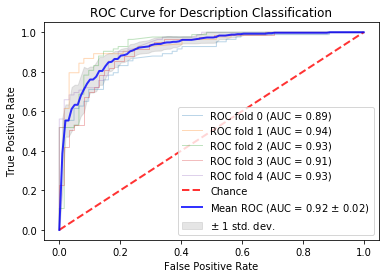

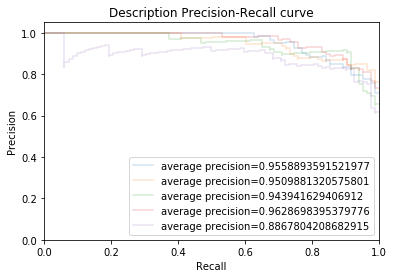

In [27]:
pipeline = make_pipeline(CountVectorizer(), LogisticRegression(solver='liblinear'))
X_train, X_test, Y_train, Y_test = train_test_split(X_desc, Y_desc)


def display_accuracy_score(y_test, y_pred_class):
    score = accuracy_score(y_test, y_pred_class)
    print('accuracy score: %s' % '{:.2%}'.format(score))
    return score

def display_null_accuracy(y_test):
    value_counts = pd.value_counts(y_test)
    null_accuracy = max(value_counts) / float(len(y_test))
    print('null accuracy: %s' % '{:.2%}'.format(null_accuracy))
    return null_accuracy

def display_accuracy_difference(y_test, y_pred_class):
    null_accuracy = display_null_accuracy(y_test)
    accuracy_score = display_accuracy_score(y_test, y_pred_class)
    difference = accuracy_score - null_accuracy
    if difference > 0:
        print('model is %s more accurate than null accuracy' % '{:.2%}'.format(difference))
    elif difference < 0:
        print('model is %s less accurate than null accuracy' % '{:.2%}'.format(abs(difference)))
    elif difference == 0:
        print('model is exactly as accurate as null accuracy')
    return null_accuracy, accuracy_score


pipeline.fit(X_train, Y_train)

y_pred_class = pipeline.predict(X_test)
y_pred_vals = pipeline.predict_proba(X_test)
results_df = pd.DataFrame({"x_test": X_test,  "y_TF_pred": y_pred_class, "y_actual": Y_test})
#print(results_df)
#print(confusion_matrix(y_test, y_pred_class))
#print('-' * 75 + '\nClassification Report\n')
print(classification_report(Y_test, y_pred_class))

display_accuracy_difference(Y_test, y_pred_class)
print('\n')
display_accuracy_score(Y_test, y_pred_class)
print('Precision score :',precision_score(Y_test, y_pred_class))
print('Recall score  :',recall_score(Y_test, y_pred_class))

print('\n')

cv = StratifiedKFold(n_splits = 5, shuffle=True)

cv_results = cross_validate(pipeline, X_desc, Y_desc, cv=5,scoring='accuracy')
print(cv_results['test_score'])
print('Mean accuracy of CV:',cv_results['test_score'].mean())

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
    
i = 0
print('Description ROC')
for train, test in cv.split(X_desc, Y_desc):
    probas_ = pipeline.fit(X_desc[train], Y_desc[train]).predict_proba(X_desc[test])
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(Y_desc[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i+=1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Description Classification')
plt.legend(loc="lower right")
plt.show()


for train, test in cv.split(X_desc, Y_desc):
    probas_ = pipeline.fit(X_desc[train], Y_desc[train]).predict_proba(X_desc[test])
    precision, recall, _ = precision_recall_curve(Y_desc[test], probas_[:,1])

    plt.step(recall, precision, alpha=0.2,
             where='post', label=f'average precision={average_precision_score(Y_desc[test], probas_[:,1])}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
plt.title('Description Precision-Recall curve'.format(
          average_precision_score(Y_desc[test], probas_[:,1])))
plt.legend(loc="lower right")
plt.show()





## 2) TfidfVectorizer + LogisticRegression

              precision    recall  f1-score   support

       False       0.94      0.62      0.75        72
        True       0.80      0.97      0.88       109

    accuracy                           0.83       181
   macro avg       0.87      0.80      0.81       181
weighted avg       0.85      0.83      0.83       181

null accuracy: 60.22%
accuracy score: 83.43%
model is 23.20% more accurate than null accuracy


accuracy score: 83.43%
Precision score : 0.7969924812030075
Recall score  : 0.9724770642201835


[0.72413793 0.8137931  0.63448276 0.75694444 0.72916667]
Mean accuracy of CV: 0.7317049808429119
Description ROC


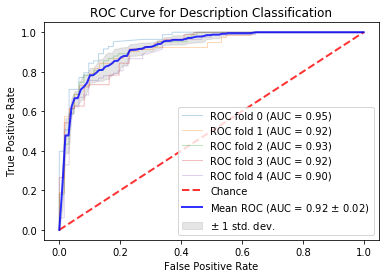

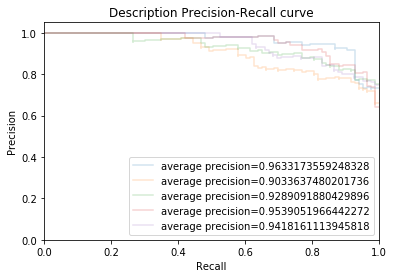

In [36]:
pipeline = make_pipeline(TfidfVectorizer(), LogisticRegression(solver='liblinear'))
X_train, X_test, Y_train, Y_test = train_test_split(X_desc, Y_desc)


def display_accuracy_score(y_test, y_pred_class):
    score = accuracy_score(y_test, y_pred_class)
    print('accuracy score: %s' % '{:.2%}'.format(score))
    return score

def display_null_accuracy(y_test):
    value_counts = pd.value_counts(y_test)
    null_accuracy = max(value_counts) / float(len(y_test))
    print('null accuracy: %s' % '{:.2%}'.format(null_accuracy))
    return null_accuracy

def display_accuracy_difference(y_test, y_pred_class):
    null_accuracy = display_null_accuracy(y_test)
    accuracy_score = display_accuracy_score(y_test, y_pred_class)
    difference = accuracy_score - null_accuracy
    if difference > 0:
        print('model is %s more accurate than null accuracy' % '{:.2%}'.format(difference))
    elif difference < 0:
        print('model is %s less accurate than null accuracy' % '{:.2%}'.format(abs(difference)))
    elif difference == 0:
        print('model is exactly as accurate as null accuracy')
    return null_accuracy, accuracy_score


pipeline.fit(X_train, Y_train)

y_pred_class = pipeline.predict(X_test)
y_pred_vals = pipeline.predict_proba(X_test)
results_df = pd.DataFrame({"x_test": X_test,  "y_TF_pred": y_pred_class, "y_actual": Y_test})
#print(results_df)
#print(confusion_matrix(y_test, y_pred_class))
#print('-' * 75 + '\nClassification Report\n')
print(classification_report(Y_test, y_pred_class))

display_accuracy_difference(Y_test, y_pred_class)
print('\n')
display_accuracy_score(Y_test, y_pred_class)
print('Precision score :',precision_score(Y_test, y_pred_class))
print('Recall score  :',recall_score(Y_test, y_pred_class))

print('\n')

cv = StratifiedKFold(n_splits = 5, shuffle=True)

cv_results = cross_validate(pipeline, X_desc, Y_desc, cv=5,scoring='accuracy')
print(cv_results['test_score'])
print('Mean accuracy of CV:',cv_results['test_score'].mean())

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
    
i = 0
print('Description ROC')
for train, test in cv.split(X_desc, Y_desc):
    probas_ = pipeline.fit(X_desc[train], Y_desc[train]).predict_proba(X_desc[test])
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(Y_desc[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i+=1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Description Classification')
plt.legend(loc="lower right")
plt.show()


for train, test in cv.split(X_desc, Y_desc):
    probas_ = pipeline.fit(X_desc[train], Y_desc[train]).predict_proba(X_desc[test])
    precision, recall, _ = precision_recall_curve(Y_desc[test], probas_[:,1])

    plt.step(recall, precision, alpha=0.2,
             where='post', label=f'average precision={average_precision_score(Y_desc[test], probas_[:,1])}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
plt.title('Description Precision-Recall curve'.format(
          average_precision_score(Y_desc[test], probas_[:,1])))
plt.legend(loc="lower right")
plt.show()




## 3) TfidfVectorizer + NaiveBayes

              precision    recall  f1-score   support

       False       0.98      0.62      0.76        76
        True       0.78      0.99      0.87       105

    accuracy                           0.83       181
   macro avg       0.88      0.80      0.82       181
weighted avg       0.86      0.83      0.83       181

null accuracy: 58.01%
accuracy score: 83.43%
model is 25.41% more accurate than null accuracy


accuracy score: 83.43%
Precision score : 0.7819548872180451
Recall score  : 0.9904761904761905


[0.73103448 0.8137931  0.65517241 0.77777778 0.75      ]
Mean accuracy of CV: 0.7455555555555555
Description ROC


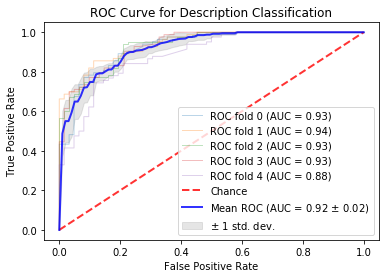

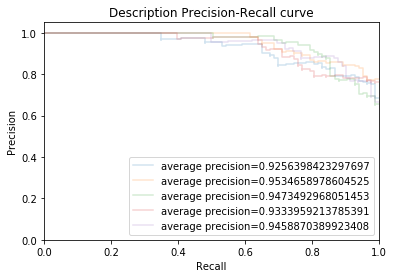

In [40]:
pipeline = make_pipeline(TfidfVectorizer(), MultinomialNB())
X_train, X_test, Y_train, Y_test = train_test_split(X_desc, Y_desc)


def display_accuracy_score(y_test, y_pred_class):
    score = accuracy_score(y_test, y_pred_class)
    print('accuracy score: %s' % '{:.2%}'.format(score))
    return score

def display_null_accuracy(y_test):
    value_counts = pd.value_counts(y_test)
    null_accuracy = max(value_counts) / float(len(y_test))
    print('null accuracy: %s' % '{:.2%}'.format(null_accuracy))
    return null_accuracy

def display_accuracy_difference(y_test, y_pred_class):
    null_accuracy = display_null_accuracy(y_test)
    accuracy_score = display_accuracy_score(y_test, y_pred_class)
    difference = accuracy_score - null_accuracy
    if difference > 0:
        print('model is %s more accurate than null accuracy' % '{:.2%}'.format(difference))
    elif difference < 0:
        print('model is %s less accurate than null accuracy' % '{:.2%}'.format(abs(difference)))
    elif difference == 0:
        print('model is exactly as accurate as null accuracy')
    return null_accuracy, accuracy_score


pipeline.fit(X_train, Y_train)

y_pred_class = pipeline.predict(X_test)
y_pred_vals = pipeline.predict_proba(X_test)
results_df = pd.DataFrame({"x_test": X_test,  "y_TF_pred": y_pred_class, "y_actual": Y_test})
#print(results_df)
#print(confusion_matrix(y_test, y_pred_class))
#print('-' * 75 + '\nClassification Report\n')
print(classification_report(Y_test, y_pred_class))

display_accuracy_difference(Y_test, y_pred_class)
print('\n')
display_accuracy_score(Y_test, y_pred_class)
print('Precision score :',precision_score(Y_test, y_pred_class))
print('Recall score  :',recall_score(Y_test, y_pred_class))

print('\n')

cv = StratifiedKFold(n_splits = 5, shuffle=True)

cv_results = cross_validate(pipeline, X_desc, Y_desc, cv=5,scoring='accuracy')
print(cv_results['test_score'])
print('Mean accuracy of CV:',cv_results['test_score'].mean())

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
    
i = 0
print('Description ROC')
for train, test in cv.split(X_desc, Y_desc):
    probas_ = pipeline.fit(X_desc[train], Y_desc[train]).predict_proba(X_desc[test])
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(Y_desc[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i+=1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Description Classification')
plt.legend(loc="lower right")
plt.show()


for train, test in cv.split(X_desc, Y_desc):
    probas_ = pipeline.fit(X_desc[train], Y_desc[train]).predict_proba(X_desc[test])
    precision, recall, _ = precision_recall_curve(Y_desc[test], probas_[:,1])

    plt.step(recall, precision, alpha=0.2,
             where='post', label=f'average precision={average_precision_score(Y_desc[test], probas_[:,1])}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
plt.title('Description Precision-Recall curve'.format(
          average_precision_score(Y_desc[test], probas_[:,1])))
plt.legend(loc="lower right")
plt.show()





## 4) TfidfVectorizer + Perceptron

In [49]:
pipeline = make_pipeline(TfidfVectorizer(), Perceptron())
X_train, X_test, Y_train, Y_test = train_test_split(X_desc, Y_desc)


def display_accuracy_score(y_test, y_pred_class):
    score = accuracy_score(y_test, y_pred_class)
    print('accuracy score: %s' % '{:.2%}'.format(score))
    return score

def display_null_accuracy(y_test):
    value_counts = pd.value_counts(y_test)
    null_accuracy = max(value_counts) / float(len(y_test))
    print('null accuracy: %s' % '{:.2%}'.format(null_accuracy))
    return null_accuracy

def display_accuracy_difference(y_test, y_pred_class):
    null_accuracy = display_null_accuracy(y_test)
    accuracy_score = display_accuracy_score(y_test, y_pred_class)
    difference = accuracy_score - null_accuracy
    if difference > 0:
        print('model is %s more accurate than null accuracy' % '{:.2%}'.format(difference))
    elif difference < 0:
        print('model is %s less accurate than null accuracy' % '{:.2%}'.format(abs(difference)))
    elif difference == 0:
        print('model is exactly as accurate as null accuracy')
    return null_accuracy, accuracy_score


pipeline.fit(X_train, Y_train)

y_pred_class = pipeline.predict(X_test)
#y_pred_vals = pipeline.predict_proba(X_test)
results_df = pd.DataFrame({"x_test": X_test,  "y_TF_pred": y_pred_class, "y_actual": Y_test})
#print(results_df)
#print(confusion_matrix(y_test, y_pred_class))
#print('-' * 75 + '\nClassification Report\n')
print(classification_report(Y_test, y_pred_class))

display_accuracy_difference(Y_test, y_pred_class)
print('\n')
display_accuracy_score(Y_test, y_pred_class)
print('Precision score :',precision_score(Y_test, y_pred_class))
print('Recall score  :',recall_score(Y_test, y_pred_class))

print('\n')

cv_results = cross_validate(pipeline, X_desc, Y_desc, cv=5,scoring='accuracy')
print(cv_results['test_score'])
print('Mean accuracy of CV:',cv_results['test_score'].mean())



              precision    recall  f1-score   support

       False       0.76      0.82      0.79        79
        True       0.85      0.80      0.83       102

    accuracy                           0.81       181
   macro avg       0.81      0.81      0.81       181
weighted avg       0.82      0.81      0.81       181

null accuracy: 56.35%
accuracy score: 81.22%
model is 24.86% more accurate than null accuracy


accuracy score: 81.22%
Precision score : 0.8541666666666666
Recall score  : 0.803921568627451


[0.73793103 0.77931034 0.71034483 0.76388889 0.79166667]
Mean accuracy of CV: 0.7566283524904214


## Trying out Cross Validation and HyperParameter Tuning

### 1) CountVectorizer+LogisticRegression

In [47]:
X_train, X_test, Y_train, Y_test = train_test_split(X_desc, Y_desc)

pipeline = make_pipeline(CountVectorizer(), LogisticRegression(penalty='l1',solver='liblinear'))
params={'logisticregression__C':[0.001,0.01,0.1,1,10,100,1000]}
clf_ridge_cv = GridSearchCV(pipeline, param_grid=params,scoring='accuracy',cv=StratifiedKFold(5))
clf_ridge_cv.fit(X_train, Y_train)

print("We get the best CV score of:",clf_ridge_cv.best_score_," when the parameters are:", clf_ridge_cv.best_params_)

pipeline = make_pipeline(CountVectorizer(), LogisticRegression(penalty='l1',C=clf_ridge_cv.best_params_['logisticregression__C'],solver='liblinear'))

def display_accuracy_score(y_test, y_pred_class):
    score = accuracy_score(y_test, y_pred_class)
    print('accuracy score: %s' % '{:.2%}'.format(score))
    return score

def display_null_accuracy(y_test):
    value_counts = pd.value_counts(y_test)
    null_accuracy = max(value_counts) / float(len(y_test))
    print('null accuracy: %s' % '{:.2%}'.format(null_accuracy))
    return null_accuracy

def display_accuracy_difference(y_test, y_pred_class):
    null_accuracy = display_null_accuracy(y_test)
    accuracy_score = display_accuracy_score(y_test, y_pred_class)
    difference = accuracy_score - null_accuracy
    if difference > 0:
        print('model is %s more accurate than null accuracy' % '{:.2%}'.format(difference))
    elif difference < 0:
        print('model is %s less accurate than null accuracy' % '{:.2%}'.format(abs(difference)))
    elif difference == 0:
        print('model is exactly as accurate as null accuracy')
    return null_accuracy, accuracy_score


pipeline.fit(X_train, Y_train)

y_pred_class = pipeline.predict(X_test)

print(confusion_matrix(Y_test, y_pred_class))
print(classification_report(Y_test, y_pred_class))

display_accuracy_difference(Y_test, y_pred_class)
print('\n')
display_accuracy_score(Y_test, y_pred_class)
print('Precision score :',precision_score(Y_test, y_pred_class))
print('Recall score  :',recall_score(Y_test, y_pred_class))



We get the best CV score of: 0.7897043832823649  when the parameters are: {'logisticregression__C': 1}
[[60 13]
 [20 88]]
              precision    recall  f1-score   support

       False       0.75      0.82      0.78        73
        True       0.87      0.81      0.84       108

    accuracy                           0.82       181
   macro avg       0.81      0.82      0.81       181
weighted avg       0.82      0.82      0.82       181

null accuracy: 59.67%
accuracy score: 81.77%
model is 22.10% more accurate than null accuracy


accuracy score: 81.77%
Precision score : 0.8712871287128713
Recall score  : 0.8148148148148148


## 2) TFIDFVectorizer + LogisticRegression

In [60]:
X_train, X_test, Y_train, Y_test = train_test_split(X_desc, Y_desc)

pipeline = make_pipeline(TfidfVectorizer(), LogisticRegression(penalty='l1',solver='liblinear'))
params={'logisticregression__C':[0.001,0.01,0.1,1,10,100,1000]}
clf_ridge_cv = GridSearchCV(pipeline, param_grid=params,scoring='accuracy',cv=StratifiedKFold(5))
clf_ridge_cv.fit(X_train, Y_train)

print("We get the best CV score of:",clf_ridge_cv.best_score_," when the parameters are:", clf_ridge_cv.best_params_)

pipeline = make_pipeline(TfidfVectorizer(), LogisticRegression(penalty='l1',C=clf_ridge_cv.best_params_['logisticregression__C'],solver='liblinear'))

def display_accuracy_score(y_test, y_pred_class):
    score = accuracy_score(y_test, y_pred_class)
    print('accuracy score: %s' % '{:.2%}'.format(score))
    return score

def display_null_accuracy(y_test):
    value_counts = pd.value_counts(y_test)
    null_accuracy = max(value_counts) / float(len(y_test))
    print('null accuracy: %s' % '{:.2%}'.format(null_accuracy))
    return null_accuracy

def display_accuracy_difference(y_test, y_pred_class):
    null_accuracy = display_null_accuracy(y_test)
    accuracy_score = display_accuracy_score(y_test, y_pred_class)
    difference = accuracy_score - null_accuracy
    if difference > 0:
        print('model is %s more accurate than null accuracy' % '{:.2%}'.format(difference))
    elif difference < 0:
        print('model is %s less accurate than null accuracy' % '{:.2%}'.format(abs(difference)))
    elif difference == 0:
        print('model is exactly as accurate as null accuracy')
    return null_accuracy, accuracy_score


pipeline.fit(X_train, Y_train)

y_pred_class = pipeline.predict(X_test)

print(confusion_matrix(Y_test, y_pred_class))
print(classification_report(Y_test, y_pred_class))

display_accuracy_difference(Y_test, y_pred_class)
print('\n')
display_accuracy_score(Y_test, y_pred_class)
print('Precision score :',precision_score(Y_test, y_pred_class))
print('Recall score  :',recall_score(Y_test, y_pred_class))




/Users/sharadsharma/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


We get the best CV score of: 0.8191811077132177  when the parameters are: {'logisticregression__C': 10}
[[64 23]
 [14 80]]
              precision    recall  f1-score   support

       False       0.82      0.74      0.78        87
        True       0.78      0.85      0.81        94

    accuracy                           0.80       181
   macro avg       0.80      0.79      0.79       181
weighted avg       0.80      0.80      0.79       181

null accuracy: 51.93%
accuracy score: 79.56%
model is 27.62% more accurate than null accuracy


accuracy score: 79.56%
Precision score : 0.7766990291262136
Recall score  : 0.851063829787234


### 3) TFIDFVectorizer + NaiveBayes (MultinomialNB)

In [68]:
X_train, X_test, Y_train, Y_test = train_test_split(X_desc, Y_desc)

pipeline = make_pipeline(TfidfVectorizer(), MultinomialNB())
params={'multinomialnb__alpha':[0.001,0.01,0.1,1,10,100,1000]}
clf_ridge_cv = GridSearchCV(pipeline, param_grid=params,scoring='accuracy',cv=StratifiedKFold(5))
clf_ridge_cv.fit(X_train, Y_train)

print("We get the best CV score of:",clf_ridge_cv.best_score_," when the parameters are:", clf_ridge_cv.best_params_)

pipeline = make_pipeline(TfidfVectorizer(), MultinomialNB(alpha=clf_ridge_cv.best_params_['multinomialnb__alpha']))

def display_accuracy_score(y_test, y_pred_class):
    score = accuracy_score(y_test, y_pred_class)
    print('accuracy score: %s' % '{:.2%}'.format(score))
    return score

def display_null_accuracy(y_test):
    value_counts = pd.value_counts(y_test)
    null_accuracy = max(value_counts) / float(len(y_test))
    print('null accuracy: %s' % '{:.2%}'.format(null_accuracy))
    return null_accuracy

def display_accuracy_difference(y_test, y_pred_class):
    null_accuracy = display_null_accuracy(y_test)
    accuracy_score = display_accuracy_score(y_test, y_pred_class)
    difference = accuracy_score - null_accuracy
    if difference > 0:
        print('model is %s more accurate than null accuracy' % '{:.2%}'.format(difference))
    elif difference < 0:
        print('model is %s less accurate than null accuracy' % '{:.2%}'.format(abs(difference)))
    elif difference == 0:
        print('model is exactly as accurate as null accuracy')
    return null_accuracy, accuracy_score


pipeline.fit(X_train, Y_train)

y_pred_class = pipeline.predict(X_test)

print(confusion_matrix(Y_test, y_pred_class))
print(classification_report(Y_test, y_pred_class))

display_accuracy_difference(Y_test, y_pred_class)
print('\n')
display_accuracy_score(Y_test, y_pred_class)
print('Precision score :',precision_score(Y_test, y_pred_class))
print('Recall score  :',recall_score(Y_test, y_pred_class))





We get the best CV score of: 0.815545361875637  when the parameters are: {'multinomialnb__alpha': 0.1}
[[43 37]
 [ 3 98]]
              precision    recall  f1-score   support

       False       0.93      0.54      0.68        80
        True       0.73      0.97      0.83       101

    accuracy                           0.78       181
   macro avg       0.83      0.75      0.76       181
weighted avg       0.82      0.78      0.77       181

null accuracy: 55.80%
accuracy score: 77.90%
model is 22.10% more accurate than null accuracy


accuracy score: 77.90%
Precision score : 0.725925925925926
Recall score  : 0.9702970297029703


### 4) TFIDFVectorizer + RandomForest (without tuning of hyp)

In [87]:
X_train, X_test, Y_train, Y_test = train_test_split(X_desc, Y_desc)

pipeline = make_pipeline(TfidfVectorizer(), RandomForestClassifier())

def display_accuracy_score(y_test, y_pred_class):
    score = accuracy_score(y_test, y_pred_class)
    print('accuracy score: %s' % '{:.2%}'.format(score))
    return score

def display_null_accuracy(y_test):
    value_counts = pd.value_counts(y_test)
    null_accuracy = max(value_counts) / float(len(y_test))
    print('null accuracy: %s' % '{:.2%}'.format(null_accuracy))
    return null_accuracy

def display_accuracy_difference(y_test, y_pred_class):
    null_accuracy = display_null_accuracy(y_test)
    accuracy_score = display_accuracy_score(y_test, y_pred_class)
    difference = accuracy_score - null_accuracy
    if difference > 0:
        print('model is %s more accurate than null accuracy' % '{:.2%}'.format(difference))
    elif difference < 0:
        print('model is %s less accurate than null accuracy' % '{:.2%}'.format(abs(difference)))
    elif difference == 0:
        print('model is exactly as accurate as null accuracy')
    return null_accuracy, accuracy_score


pipeline.fit(X_train, Y_train)

y_pred_class = pipeline.predict(X_test)

print(confusion_matrix(Y_test, y_pred_class))
print(classification_report(Y_test, y_pred_class))

display_accuracy_difference(Y_test, y_pred_class)
print('\n')
display_accuracy_score(Y_test, y_pred_class)
print('Precision score :',precision_score(Y_test, y_pred_class))
print('Recall score  :',recall_score(Y_test, y_pred_class))






[[58 13]
 [25 85]]
              precision    recall  f1-score   support

       False       0.70      0.82      0.75        71
        True       0.87      0.77      0.82       110

    accuracy                           0.79       181
   macro avg       0.78      0.79      0.79       181
weighted avg       0.80      0.79      0.79       181

null accuracy: 60.77%
accuracy score: 79.01%
model is 18.23% more accurate than null accuracy


accuracy score: 79.01%
Precision score : 0.8673469387755102
Recall score  : 0.7727272727272727


### 5) TFIDFVectorizer + RandomForest (with tuning of hyp)

In [100]:
X_train, X_test, Y_train, Y_test = train_test_split(X_desc, Y_desc)

#pipeline = make_pipeline(TfidfVectorizer(), RandomForestClassifier())
#params={'randomforestclassifier__n_estimators':range(100,200,20),'randomforestclassifier__max_depth':range(3,10,2),'randomforestclassifier__max_features':["auto", "sqrt", "log2"]}
#clf_ridge_cv = GridSearchCV(pipeline, param_grid=params,scoring='accuracy',cv=StratifiedKFold(5))
#clf_ridge_cv.fit(X_train, Y_train)

#print("We get the best CV score of:",clf_ridge_cv.best_score_," when the parameters are:", clf_ridge_cv.best_params_)

#We get the best CV score of: 0.806218144750255  when the parameters are: {'randomforestclassifier__max_depth': 9, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 100}
pipeline = make_pipeline(TfidfVectorizer(), RandomForestClassifier(max_depth=9,max_features='sqrt',n_estimators=100))

def display_accuracy_score(y_test, y_pred_class):
    score = accuracy_score(y_test, y_pred_class)
    print('accuracy score: %s' % '{:.2%}'.format(score))
    return score

def display_null_accuracy(y_test):
    value_counts = pd.value_counts(y_test)
    null_accuracy = max(value_counts) / float(len(y_test))
    print('null accuracy: %s' % '{:.2%}'.format(null_accuracy))
    return null_accuracy

def display_accuracy_difference(y_test, y_pred_class):
    null_accuracy = display_null_accuracy(y_test)
    accuracy_score = display_accuracy_score(y_test, y_pred_class)
    difference = accuracy_score - null_accuracy
    if difference > 0:
        print('model is %s more accurate than null accuracy' % '{:.2%}'.format(difference))
    elif difference < 0:
        print('model is %s less accurate than null accuracy' % '{:.2%}'.format(abs(difference)))
    elif difference == 0:
        print('model is exactly as accurate as null accuracy')
    return null_accuracy, accuracy_score


pipeline.fit(X_train, Y_train)

y_pred_class = pipeline.predict(X_test)

print(confusion_matrix(Y_test, y_pred_class))
print(classification_report(Y_test, y_pred_class))

display_accuracy_difference(Y_test, y_pred_class)
print('\n')
display_accuracy_score(Y_test, y_pred_class)
print('Precision score :',precision_score(Y_test, y_pred_class))
print('Recall score  :',recall_score(Y_test, y_pred_class))


[[56 32]
 [11 82]]
              precision    recall  f1-score   support

       False       0.84      0.64      0.72        88
        True       0.72      0.88      0.79        93

    accuracy                           0.76       181
   macro avg       0.78      0.76      0.76       181
weighted avg       0.78      0.76      0.76       181

null accuracy: 51.38%
accuracy score: 76.24%
model is 24.86% more accurate than null accuracy


accuracy score: 76.24%
Precision score : 0.7192982456140351
Recall score  : 0.8817204301075269


### 6) TFIDFVectorizer + XGBClassifier (no tuning)

In [121]:
X_train, X_test, Y_train, Y_test = train_test_split(X_desc, Y_desc)

pipeline = make_pipeline(CountVectorizer(), XGBClassifier())

def display_accuracy_score(y_test, y_pred_class):
    score = accuracy_score(y_test, y_pred_class)
    print('accuracy score: %s' % '{:.2%}'.format(score))
    return score

def display_null_accuracy(y_test):
    value_counts = pd.value_counts(y_test)
    null_accuracy = max(value_counts) / float(len(y_test))
    print('null accuracy: %s' % '{:.2%}'.format(null_accuracy))
    return null_accuracy

def display_accuracy_difference(y_test, y_pred_class):
    null_accuracy = display_null_accuracy(y_test)
    accuracy_score = display_accuracy_score(y_test, y_pred_class)
    difference = accuracy_score - null_accuracy
    if difference > 0:
        print('model is %s more accurate than null accuracy' % '{:.2%}'.format(difference))
    elif difference < 0:
        print('model is %s less accurate than null accuracy' % '{:.2%}'.format(abs(difference)))
    elif difference == 0:
        print('model is exactly as accurate as null accuracy')
    return null_accuracy, accuracy_score


pipeline.fit(X_train, Y_train)

y_pred_class = pipeline.predict(X_test)

print(confusion_matrix(Y_test, y_pred_class))
print(classification_report(Y_test, y_pred_class))

display_accuracy_difference(Y_test, y_pred_class)
print('\n')
display_accuracy_score(Y_test, y_pred_class)
print('Precision score :',precision_score(Y_test, y_pred_class))
print('Recall score  :',recall_score(Y_test, y_pred_class))


[[64 15]
 [23 79]]
              precision    recall  f1-score   support

       False       0.74      0.81      0.77        79
        True       0.84      0.77      0.81       102

    accuracy                           0.79       181
   macro avg       0.79      0.79      0.79       181
weighted avg       0.79      0.79      0.79       181

null accuracy: 56.35%
accuracy score: 79.01%
model is 22.65% more accurate than null accuracy


accuracy score: 79.01%
Precision score : 0.8404255319148937
Recall score  : 0.7745098039215687


### 7) TFIDFVectorizer + XGBClassifier (with hyperparameter tuning)

In [126]:
X_train, X_test, Y_train, Y_test = train_test_split(X_desc, Y_desc)
pipeline = make_pipeline(TfidfVectorizer(), XGBClassifier())
param_test1 = {
 'xgbclassifier__max_depth':range(3,10,2),
 'xgbclassifier__min_child_weight':range(1,6,2),
 'xgbclassifier__learning_rate':[0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] 
}
gsearch1 = GridSearchCV(pipeline,param_grid=param_test1,scoring='accuracy', cv=StratifiedKFold(5))

gsearch1.fit(X_train,Y_train)
print(gsearch1.best_params_)
print(gsearch1.best_score_)

{'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 5, 'xgbclassifier__min_child_weight': 1}
0.7878185524974516


In [127]:
param_test2 = {
 'xgbclassifier__n_estimators':range(100,200,20)
}
pipeline = make_pipeline(TfidfVectorizer(), XGBClassifier(max_depth=5,min_child_weight=1,learning_rate=0.1))
gsearch2 = GridSearchCV(pipeline,param_grid=param_test2,scoring='accuracy', cv=StratifiedKFold(5))

gsearch2.fit(X_train,Y_train)
print(gsearch2.best_params_)
print(gsearch2.best_score_)

{'xgbclassifier__n_estimators': 100}
0.7878185524974516


In [128]:
param_test3 = {
 'xgbclassifier__gamma':[i/10.0 for i in range(0,5)]
}
pipeline = make_pipeline(TfidfVectorizer(), XGBClassifier(max_depth=5,min_child_weight=1,learning_rate=0.1,n_estimators=100))
gsearch2 = GridSearchCV(pipeline,param_grid=param_test3,scoring='accuracy', cv=StratifiedKFold(5))

gsearch2.fit(X_train,Y_train)
print(gsearch2.best_params_)
print(gsearch2.best_score_)

{'xgbclassifier__gamma': 0.1}
0.7915222562011553


In [129]:
param_test4 = {
 'xgbclassifier__subsample':[i/10.0 for i in range(6,10)],
 'xgbclassifier__colsample_bytree':[i/10.0 for i in range(6,10)]
}

pipeline = make_pipeline(TfidfVectorizer(), XGBClassifier(max_depth=5,min_child_weight=1,learning_rate=0.1,n_estimators=100,gamma=0.1))
gsearch2 = GridSearchCV(pipeline,param_grid=param_test4,scoring='accuracy', cv=StratifiedKFold(5))

gsearch2.fit(X_train,Y_train)
print(gsearch2.best_params_)
print(gsearch2.best_score_)

{'xgbclassifier__colsample_bytree': 0.9, 'xgbclassifier__subsample': 0.8}
0.7915902140672783


In [130]:
param_test5 = {
 'xgbclassifier__reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

pipeline = make_pipeline(TfidfVectorizer(), XGBClassifier(max_depth=5,min_child_weight=1,learning_rate=0.1,n_estimators=100,gamma=0.1,colsample_bytree=0.9,subsample=0.8))
gsearch2 = GridSearchCV(pipeline,param_grid=param_test5,scoring='accuracy', cv=StratifiedKFold(5))

gsearch2.fit(X_train,Y_train)
print(gsearch2.best_params_)
print(gsearch2.best_score_)

{'xgbclassifier__reg_alpha': 1e-05}
0.7915902140672783


In [141]:
pipeline = make_pipeline(TfidfVectorizer(), XGBClassifier(max_depth=5,min_child_weight=1,learning_rate=0.1,n_estimators=100,gamma=0.1,colsample_bytree=0.9,subsample=0.8,
                                                         reg_alpha=1e-05))
pipeline.fit(X_train,Y_train)
y_pred_class = pipeline.predict(X_test)

print(confusion_matrix(Y_test, y_pred_class))
print(classification_report(Y_test, y_pred_class))

display_accuracy_difference(Y_test, y_pred_class)
print('\n')
display_accuracy_score(Y_test, y_pred_class)
print('Precision score :',precision_score(Y_test, y_pred_class))
print('Recall score  :',recall_score(Y_test, y_pred_class))






[[63 21]
 [23 74]]
              precision    recall  f1-score   support

       False       0.73      0.75      0.74        84
        True       0.78      0.76      0.77        97

    accuracy                           0.76       181
   macro avg       0.76      0.76      0.76       181
weighted avg       0.76      0.76      0.76       181

null accuracy: 53.59%
accuracy score: 75.69%
model is 22.10% more accurate than null accuracy


accuracy score: 75.69%
Precision score : 0.7789473684210526
Recall score  : 0.7628865979381443


## Carrying out feature selection on the top model

### 1)TfidfVectorizer+LogisticRegression (L2 Penalty with hyperparameter tuning)

In [182]:
X_train, X_test, Y_train, Y_test = train_test_split(X_desc, Y_desc)

pipeline = make_pipeline(TfidfVectorizer(),SelectFromModel(RandomForestClassifier()),LogisticRegression(penalty='l2',solver='liblinear'))
params={'logisticregression__C':[0.001,0.01,0.1,1,10,100,1000]}
clf_ridge_cv = GridSearchCV(pipeline, param_grid=params,scoring='accuracy',cv=StratifiedKFold(5))
clf_ridge_cv.fit(X_train, Y_train)

print("We get the best CV score of:",clf_ridge_cv.best_score_," when the parameters are:", clf_ridge_cv.best_params_)

pipeline = make_pipeline(TfidfVectorizer(),SelectFromModel(RandomForestClassifier()), LogisticRegression(penalty='l2',C=clf_ridge_cv.best_params_['logisticregression__C'],solver='liblinear'))

def display_accuracy_score(y_test, y_pred_class):
    score = accuracy_score(y_test, y_pred_class)
    print('accuracy score: %s' % '{:.2%}'.format(score))
    return score

def display_null_accuracy(y_test):
    value_counts = pd.value_counts(y_test)
    null_accuracy = max(value_counts) / float(len(y_test))
    print('null accuracy: %s' % '{:.2%}'.format(null_accuracy))
    return null_accuracy

def display_accuracy_difference(y_test, y_pred_class):
    null_accuracy = display_null_accuracy(y_test)
    accuracy_score = display_accuracy_score(y_test, y_pred_class)
    difference = accuracy_score - null_accuracy
    if difference > 0:
        print('model is %s more accurate than null accuracy' % '{:.2%}'.format(difference))
    elif difference < 0:
        print('model is %s less accurate than null accuracy' % '{:.2%}'.format(abs(difference)))
    elif difference == 0:
        print('model is exactly as accurate as null accuracy')
    return null_accuracy, accuracy_score


pipeline.fit(X_train, Y_train)

y_pred_class = pipeline.predict(X_test)

print(confusion_matrix(Y_test, y_pred_class))
print(classification_report(Y_test, y_pred_class))

display_accuracy_difference(Y_test, y_pred_class)
print('\n')
display_accuracy_score(Y_test, y_pred_class)
print('Precision score :',precision_score(Y_test, y_pred_class))
print('Recall score  :',recall_score(Y_test, y_pred_class))





We get the best CV score of: 0.821083927964662  when the parameters are: {'logisticregression__C': 10}
[[61 13]
 [12 95]]
              precision    recall  f1-score   support

       False       0.84      0.82      0.83        74
        True       0.88      0.89      0.88       107

    accuracy                           0.86       181
   macro avg       0.86      0.86      0.86       181
weighted avg       0.86      0.86      0.86       181

null accuracy: 59.12%
accuracy score: 86.19%
model is 27.07% more accurate than null accuracy


accuracy score: 86.19%
Precision score : 0.8796296296296297
Recall score  : 0.8878504672897196
